<a href="https://colab.research.google.com/github/JatinderKumarChaurasia/DL_Assignment/blob/main/DataPredemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy import vstack
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, precision_score, average_precision_score,recall_score, f1_score
from sklearn.metrics import *
# from torch.utils.data import TensorDataset
from torch import nn
from torch.nn import functional as F

**Check the GPU availability**

In [2]:
gpu = torch.cuda.is_available()
print(f"Is the GPU available? {gpu}")

Is the GPU available? True


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


**Mounting Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Checking for missing values**

In [5]:
gdrive_path = '/content/drive/My Drive/data.csv'
df_data=pd.read_csv(gdrive_path)
df_data.columns
tmp = df_data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]
# no missing value



,index,missing_val


**Print row number 49 to row 57 from input dataset along with its feature values**

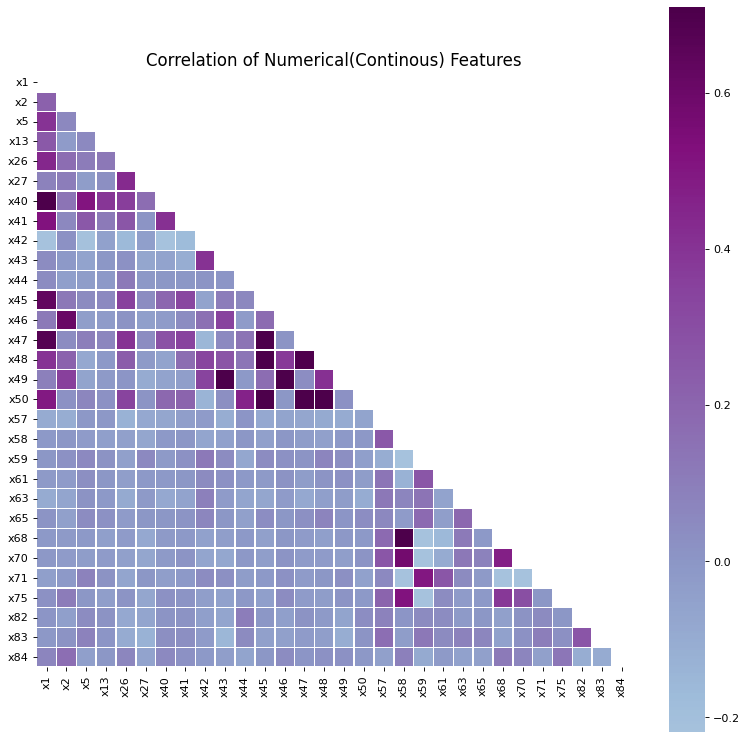

In [6]:
# my_csv.dropna()
# data=my_csv.drop(columns='T',inplace=True)
# target=my_csv.T
likely_cat = {}
for var in df_data.iloc[:,:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

#Taking all columns except URL 
corr = df_data[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of Numerical(Continous) Features', fontsize=15)
plt.show()

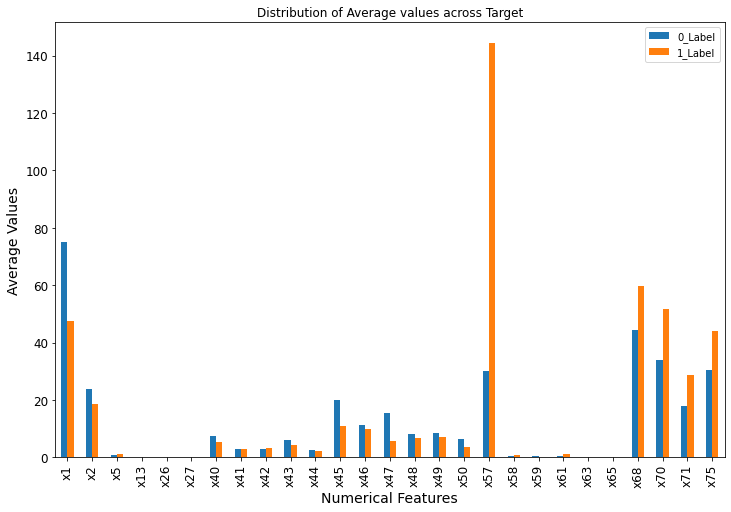

In [7]:
df_distr =df_data.groupby('T')[num_cols].mean().reset_index().T
df_distr.rename(columns={0:'0_Label',1:"1_Label"}, inplace=True)

#plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['0_Label','1_Label']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
#ax.set_ylim(0,500000)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


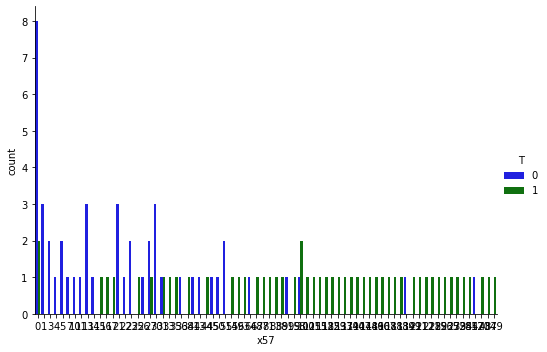

In [8]:
sns.catplot("x57", hue="T", data=df_data.head(100), kind="count",
            palette={1:"green", 0:"blue"} ,height=5.0, aspect=11.7/8.27 )

**Split the data into train set(80% of data points) and testset(20% of data)**

In [9]:
x= df_data.iloc[: , :-1]
y = df_data['T']
print(type(y))
print("shape of x: {}\nshape of y: {} \nfeatures: {}\n ".format(x.shape,y.shape,x.columns))

<class 'pandas.core.series.Series'>
shape of x: (11430, 87)
shape of y: (11430,) 
features: Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41',
       'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51',
       'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61',
       'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71',
       'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81',
       'x82', 'x83', 'x84', 'x85', 'x86', 'x87'],
      dtype='object')
 


In [10]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2, train_size=0.8,shuffle=True)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(9144, 87)
(9144,)
(2286, 87)
(2286,)


**Model Development**
**a) Build the Fully connected Deep Neural Network**
**b) Experiment with number of hidden layers, and number of neurons in the network**

In [11]:
class DataLine(Dataset):
  # scaled using MinMaxScalar
  def __init__(self,path=None,target_variable:str=None,do_split:bool=False,split_ratio:float=0.1,split_shuffle:bool=False,do_scale:bool=False,convert_to_tensor:bool=False):
    self.df_data=pd.read_csv(gdrive_path)
    self.x= self.df_data.drop([target_variable],axis=1) # features
    self.y = self.df_data[[target_variable]] # target_variables = T
    self.split_ratio=split_ratio
    self.split_shuffle=split_shuffle
    self.feature_set_columns,self.feature_set_shape= self.x.columns.values,self.x.shape
    self.test_set_columns,test_set_shape=self.y.columns,self.y.shape
    if do_split:
      self.train_x,self.test_x,self.train_y,self.test_y= self.split(test_ratio=self.split_ratio,shuffle=self.split_shuffle)
    else:
      self.train_x,self.test_x,self.train_y,self.test_y = None,None,None,None
    if do_scale and do_split:
      print('Scaling Training Data')
      scaler = preprocessing.MinMaxScaler()
      self.x_train = scaler.fit_transform(self.train_x.values)
      self.x_test =  scaler.fit_transform(self.test_x.values)
      print("Scaled values of Train set and Type \n")
      print(self.x_train,type(self.x_train))
      print("\nScaled values of Test set and Type \n")
      print(self.x_test,type(self.x_test))
    else:
      self.x_train,self.x_test=self.train_x,self.test_x
    if do_split and convert_to_tensor:
      print('Converting to tensor')
      self.x_tensor =  torch.from_numpy(self.x_train).float().to(device)
      self.y_tensor =  torch.from_numpy(self.train_y.values.ravel()).float().to(device)
      self.xtest_tensor =  torch.from_numpy(self.x_test).float().to(device)
      self.ytest_tensor =  torch.from_numpy(self.test_y.values.ravel()).float().to(device)
    else:
      self.x_tensor,self.y_tensor,self.xtest_tensor,self.ytest_tensor= None,None,None,None
    
    print("Feature Set Columns: {} and Shape: {}".format(self.x.columns,self.x.shape))
    print("Test_Variable Column: {} and Shape: {}".format(self.y.columns,self.y.shape))
    # self.x = torch.tensor(input_set.values,dtype=torch.float32)
    # self.y = torch.tensor(target_set.values,dtype=torch.float32)
    self.length = self.x.shape

  # def get_pre_processed_data(self,dataframe: pd.DataFrame):
  #   print('checking if there is null value')
  #   print(dataframe.isnull().sum().sum())
  #   return dataframe
  
  def get_summary_of_dataset(self):
    pass

  def get_visuals(self):
    pass
    
    
  def __getitem__(self, index):
      return self.x[index],self.y[index]
      # row = self.dataframe.iloc[index].to_numpy()
      # features = row[1:]
      # label = row[0]
      # return features, label

  def __len__(self):
      return len(self.x)

  def split(self,test_ratio:float = 0.1,shuffle: bool = False):
    
    if test_ratio > 1 or test_ratio <= 0:
      raise Exception("Invalid test_ratio, need to be in between 0 and 1 , found ratio: {}".format(test_ratio))
    train_ratio= 1- test_ratio
    print("Splitting Train Ratio: {}, Test_Ratio: {}".format(train_ratio,test_ratio))
    train_x,test_x,train_y,test_y= train_test_split(self.x,self.y,test_size=test_ratio,train_size=train_ratio,shuffle=shuffle)
    print("TrainingSet_X Shape: {} \nTestSet_X Shape: {} \nTraining_Set_Y Shape: {} \nTest_Set_Y: {}".format(train_x.shape,test_x.shape,train_y.shape,test_y.shape))
    return train_x,test_x,train_y,test_y
    # if scale == True:
    #   print('Scaling Training Data')
    #   scaler = preprocessing.MinMaxScaler()
    #   x_train = scaler.fit_transform(train_x.values)
    #   x_test =  scaler.fit_transform(test_x.values)
    #   print("Scaled values of Train set and Type \n")
    #   print(x_train,type(x_train))
    #   print("\nScaled values of Test set and Type \n")
    #   print(x_test,type(x_test))
    # else:
    #   x_train,x_test= train_x,test_x
    # if convert_to_tensor == True:
    #   print('Converting to tensor')
    #   x_tensor =  torch.from_numpy(x_train).float()
    #   y_tensor =  torch.from_numpy(train_y.values.ravel()).float()
    #   xtest_tensor =  torch.from_numpy(x_test).float()
    #   ytest_tensor =  torch.from_numpy(test_y.values.ravel()).float()
    # else:
    #   x_tensor,y_tensor,xtest_tensor,ytest_tensor=x_train,train_y,x_test,test_y
    # return x_tensor,y_tensor,xtest_tensor,ytest_tensor


Splitting Train Ratio: 0.8, Test_Ratio: 0.2
TrainingSet_X Shape: (9144, 87) 
TestSet_X Shape: (2286, 87) 
Training_Set_Y Shape: (9144, 1) 
Test_Set_Y: (2286, 1)
Scaling Training Data
Scaled values of Train set and Type 

[[0.01534684 0.07142857 0.         ... 1.         1.         0.4       ]
 [0.03990178 0.09047619 1.         ... 0.         1.         0.2       ]
 [0.06998158 0.21904762 1.         ... 0.         1.         0.        ]
 ...
 [0.01411909 0.04285714 0.         ... 0.         0.         0.5       ]
 [0.04051565 0.06666667 0.         ... 0.         0.         0.4       ]
 [0.01350522 0.1047619  0.         ... 0.         0.         0.1       ]] <class 'numpy.ndarray'>

Scaled values of Test set and Type 

[[0.04990403 0.07142857 0.         ... 0.         1.         0.        ]
 [0.02111324 0.06190476 0.         ... 0.         0.         0.4       ]
 [0.09021113 0.05238095 0.         ... 0.         1.         0.        ]
 ...
 [0.17274472 0.05714286 1.         ... 0.        

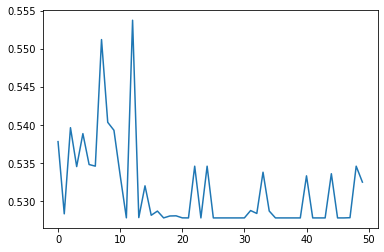

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


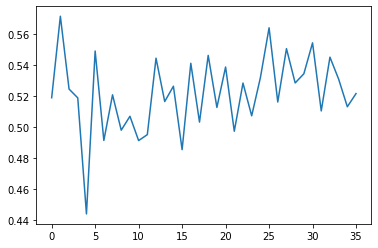

,metric_type,metric
0,accuracy,0.947069
1,AU_ROC,0.947644
2,f1_score,0.947460
3,average_precision_score,0.935270
4,f_beta,0.947460
5,matthews_correlation_coefficient,0.895003
6,precision,0.968057
7,recall,0.927721
8,true_positive_rate_TPR,0.927721
9,false_positive_rate_FPR,0.032432


In [12]:
# DataSet
data_line = DataLine(path=gdrive_path,target_variable='T',do_split=True,split_ratio=0.2,convert_to_tensor=True,do_scale=True)
x_tensor,y_tensor,xtest_tensor,ytest_tensor = data_line.x_tensor,data_line.y_tensor,data_line.xtest_tensor,data_line.ytest_tensor
data_line.get_summary_of_dataset()
data_line.get_visuals()

print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=64)


#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

# trainloader = DataLoader(data_line,batch_size=64,shuffle=False)
dimensions_of_training_set=data_line.train_x.shape[1]
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(dimensions_of_training_set, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
      # softmax ,leakyrelu,
        x = self.relu(self.layer_1(inputs)) # activation function
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x)) # activation function
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x)) # activation function
        return x

learning_rate=0.2   
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassification().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()
print(model)

# from torch import nn
# from torch.nn import functional as F
# class Net(nn.Module):
#   desf __init__(self,input_shape):
#     super(Net,self).__init__()
#     self.fc1 = nn.Linear(input_shape,32)
#     self.fc2 = nn.Linear(32,64)
#     self.fc3 = nn.Linear(64,1)
#   def forward(self,x):
#     x = torch.relu(self.fc1(x))
#     x = torch.relu(self.fc2(x))
#     x = torch.sigmoid(self.fc3(x))
#     return x

learning_rate = 0.01
epochs = 700
import time

def train_model(train_dl, model, epochs=50, lr=0.01, momentum=0.9, save_path='datapredemo.pth'):
    # Define your optimisation function for reducing loss when weights are calculated 
    # and propogated through the network
    start = time.time()
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    loss = 0.0
    train_loss = []
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        model.train()
        # Iterate through training data loader
        for i, (inputs, yb) in enumerate(train_dl):
            optimizer.zero_grad()
            y_pred = model(inputs)
            _, preds = torch.max(y_pred.data,1) #Get the class labels
            loss = loss_function(y_pred, yb)
            loss.backward()
            optimizer.step()
        torch.save(model, save_path)
        train_loss.append(loss.item())
    print('Last iteration loss value: '+str(loss.item()))
    time_delta = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_delta // 60, time_delta % 60
    ))
    plt.plot(train_loss)
    plt.show()
    return model


train_model(train_dl,model,epochs=50,lr=0.02)
import math,itertools
def evaluate_model(test_dl, model, beta=0.1):
    preds = []
    loss_function = nn.BCEWithLogitsLoss()
    actuals = []
    test_loss=[]
    model.eval()
    with torch.no_grad():
      for (i, (inputs, targets)) in enumerate(test_dl):
          #Evaluate the model on the test set
          inputs,targets = inputs.to(device),targets.to(device)
          print(i)
          yhat = model(inputs)
          # y_test_pred = model(xb_test)
          y_pred_tag = torch.round(yhat)
          # print(y_pred_tag)
          preds.append(y_pred_tag.cpu().detach().numpy())
          #Retrieve a numpy weights array
          # yhat = yhat.detach().numpy()
          loss = loss_function(yhat, targets)
          # loss.backward()
          # print(loss)
          # Extract the weights using detach to get the numerical values in an ndarray, instead of tensor
          actual = targets.cpu().numpy()
          actual = actual.reshape((len(actual), 1))
          # Round to get the class value i.e. sick vs not sick
          # yhat = yhat.round()
          # Store the predictions in the empty lists initialised at the start of the class
          # preds.append(yhat)
          actuals.append(actual)
          test_loss.append(loss.item())
      plt.plot(test_loss)
      plt.show()
    # Stack the predictions and actual arrays vertically
    preds, actuals = vstack(preds), vstack(actuals)
    #Calculate metrics
    y_pred_list = [a.squeeze().tolist() for a in preds]
    #flattens the lists in sequence
    ytest_pred = list(itertools.chain.from_iterable(preds))
    cm = confusion_matrix(actuals, preds)
    # Get descriptions of tp, tn, fp, fn
    tn, fp, fn, tp = cm.ravel()
    total = sum(cm.ravel())
    
    metrics = {
        'accuracy': accuracy_score(actuals, preds),
        'AU_ROC': roc_auc_score(actuals, preds),
        'f1_score': f1_score(actuals, preds),
        'average_precision_score': average_precision_score(actuals, preds),
        'f_beta': ((1+beta**2) * precision_score(actuals, preds) * recall_score(actuals, preds)) / (beta**2 * precision_score(actuals, preds) + recall_score(actuals, preds)),
        'matthews_correlation_coefficient': (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)),
        'precision': precision_score(actuals, preds),
        'recall': recall_score(actuals, preds),
        'true_positive_rate_TPR':recall_score(actuals, preds),
        'false_positive_rate_FPR':fp / (fp + tn) ,
        'false_discovery_rate': fp / (fp +tp),
        'false_negative_rate': fn / (fn + tp) ,
        'negative_predictive_value': tn / (tn+fn),
        'misclassification_error_rate': (fp+fn)/total ,
        'sensitivity': tp / (tp + fn),
        'specificity': tn / (tn + fp),
        #'confusion_matrix': confusion_matrix(actuals, preds), 
        'TP': tp,
        'FP': fp, 
        'FN': fn, 
        'TN': tn
    }
    return metrics, preds, actuals

results = evaluate_model(test_loader, model, beta=1)
model_metrics = results[0]
metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['metric'])
metrics_df.index.name = 'metric_type'
metrics_df.reset_index(inplace=True)
metrics_df
# Model , Optimizer, Loss
# model = Net(input_shape=x.shape[1]).to()
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# loss_fn = nn.BCELoss()

# #forward loop
# losses = []
# accur = []
# for i in range(epochs):
#   for j,(x_train,y_train) in enumerate(trainloader):
    
#     #calculate output
#     output = model(x_train)
 
#     #calculate loss
#     loss = loss_fn(output,y_train.reshape(-1,1))
 
#     #accuracy
#     predicted = model(torch.tensor(x.values,dtype=torch.float32))
#     acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
#     #backprop
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#   if i%50 == 0:
#     losses.append(loss)
#     accur.append(acc)
#     print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

# # train_dataloader = DataLoader(data_line, batch_size=64, shuffle=True)
# # test_dataloader = DataLoader(data_line, batch_size=64, shuffle=True)
# # # dataloader.batch_size
# # # for sample in dataloader:
# # #     print(sample)

# # for i in range(len(train_dataloader)):
# #     sample = train_dataloader[i]

#     print(i, sample['image'].size(), sample['landmarks'].size())

#     if i == 3:
#         break

# loss_func = nn.BCELoss()
# #Optimizer
# learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# epochs = 50

# model.train()
# train_loss = []
# for epoch in range(epochs):
#     #Within each epoch run the subsets of data = batch sizes.
#     for xb, yb in train_dl:
#         y_pred = model(xb)            # Forward Propagation
#         loss = loss_func(y_pred, yb)  # Loss Computation
#         optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
#         loss.backward()               # Back Propagation
#         optimizer.step()              # Updating the parameters 
#     #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
#     train_loss.append(loss.item())
# print('Last iteration loss value: '+str(loss.item()))
# plt.plot(train_loss)
# plt.show()

In [ ]:
print()